In [ ]:
pip install scikit-learn


In [3]:
from collections import Counter
import numpy as np
import pandas as pd
from requests import head
import seaborn as sns
import matplotlib.pyplot as plt 
import time
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from matplotlib import pyplot as plt
from wordcloud import WordCloud
from matplotlib import colormaps
import matplotlib.animation as animation
from sklearn.feature_extraction.text import CountVectorizer


In [9]:
import sys 
import os 

# Adicionando o diretório do projeto ao sys.path
project_path = os.path.abspath(os.path.join(os.path.dirname('__file__'), '..'))
sys.path.append(project_path)

import utilities.utilities as u

In [19]:
import re

# Função de limpeza de texto
def preprocess_text(text):
    # Remover pontuação, números e símbolos especiais
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Converter para minúsculas
    text = text.lower()
    return text

In [22]:
# df_clean = pd.read_csv('cleaned_data/dados_limpos.csv')
df_original = pd.read_csv('../data/fake_and_real_news.csv')

df_clean = pd.DataFrame({'Text': [], 'label': []})

df_clean['Text'] = df_original['Text'].apply(preprocess_text)

mapeamento = {'Real': 1, 'Fake': 0}
   
# cópia e escrita em disco da coluna 'label' normalizada para o dataframe que contém os dados limpos 
df_clean['label'] = df_original['label'].map(mapeamento)

df_clean.to_csv('../cleaned_data/cleaned_texts.csv', index=False)


In [23]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
import string
import os
from wordcloud import WordCloud
from collections import Counter 
from itertools import repeat, chain
from scipy.spatial.distance import cosine
import numpy as np
from scipy.stats import pearsonr

In [25]:
df_clean = pd.read_csv('../cleaned_data/cleaned_texts.csv')

print(df_clean.head())

                                                Text  label
0   top trump surrogate brutally stabs him in the...      0
1  us conservative leader optimistic of common gr...      1
2  trump proposes us tax overhaul stirs concerns ...      1
3   court forces ohio to allow millions of illega...      0
4  democrats say trump agrees to work on immigrat...      1


In [28]:
df_clean = pd.read_csv('../cleaned_data/cleaned_texts.csv')

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [29]:

# Inicializando o CountVectorizer
vectorizer = CountVectorizer()

# Ajustando o modelo e transformando os dados
X = vectorizer.fit_transform(df_clean['Text'])

# Convertendo a matriz resultante para um DataFrame
bag_of_words = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

print(bag_of_words)

      aa  aaa  aaaaackkk  aaaarrgh  aaccording  aaf  aafter  aai  aaja  \
0      0    0          0         0           0    0       0    0     0   
1      0    0          0         0           0    0       0    0     0   
2      0    0          0         0           0    0       0    0     0   
3      0    0          0         0           0    0       0    0     0   
4      0    0          0         0           0    0       0    0     0   
...   ..  ...        ...       ...         ...  ...     ...  ...   ...   
9895   0    0          0         0           0    0       0    0     0   
9896   0    0          0         0           0    0       0    0     0   
9897   0    0          0         0           0    0       0    0     0   
9898   0    0          0         0           0    0       0    0     0   
9899   0    0          0         0           0    0       0    0     0   

      aalberts  ...  zullo  zuppello  zyklon  zypries  zyries  zz  \
0            0  ...      0         0      

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

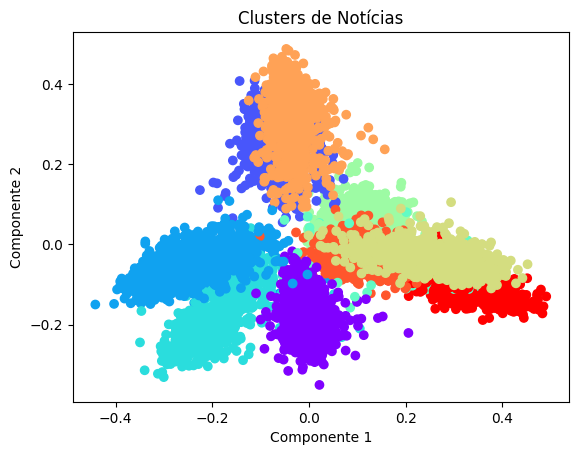

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from scipy.sparse import vstack

# Inicializando o TfidfVectorizer com 1000 features, pois o conjunto todo é muito grande e resulta em sobrecarga de memória 
vectorizer = TfidfVectorizer(max_features=1000)

# Processamento em partes menores (Chunking) para evitar sobrecarregar a memória.
chunk_size = 1000 
chunks = [df_clean['Text'][i:i + chunk_size] for i in range(0, cleaned_texts.shape[0], chunk_size)]

# Cada parte é transformada usando o TfidfVectorizer.
tfidf_chunks = [vectorizer.fit_transform(chunk) for chunk in chunks]
x = vstack(tfidf_chunks)

# Utilizando o MiniBatchKMeans, que é uma variação de K-means projetada para trabalhar com grandes conjuntos de dados. 
# Ele processa os dados em mini-batches, reduzindo o uso de memória.
num_clusters = 10
kmeans = MiniBatchKMeans(n_clusters= num_clusters, random_state=0, batch_size=chunk_size).fit(x)

# # Adicionando os rótulos dos clusters ao DataFrame original
df_clean['Cluster'] = kmeans.labels_


# Visualizando os clusters com PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(x.toarray())

plt.scatter(principal_components[:, 0], principal_components[:, 1], c=kmeans.labels_, cmap='rainbow')
plt.title('Clusters de Notícias')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
# plt.savefig('../images/clusterizacao_num10.png', dpi=300)
plt.show()

Classificação

In [56]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [60]:
# Separar as características e o alvo
# X contém o texto das notícias e y contém os rótulos (label).
x = df_clean['Text']
y = df_clean['label']

# Dividir em conjuntos de treino e teste
# Usa train_test_split para dividir os dados em conjuntos de treino e teste.
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Inicializando o TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=1000)

# Transformar o texto em vetores TF-IDF
# Usa TfidfVectorizer para transformar o texto em vetores TF-IDF.
x_train_tfidf = vectorizer.fit_transform(x_train)
x_test_tfidf = vectorizer.transform(x_test)

# Inicializando os modelos
models = {
    "Decision Tree": DecisionTreeClassifier(),
    "Gaussian Naive Bayes": GaussianNB(),
    "Linear Discriminant Analysis": make_pipeline(StandardScaler(with_mean=False), LinearDiscriminantAnalysis()),
    "K-Nearest Neighbors": KNeighborsClassifier()
}

# Treinando e avaliando cada modelo
for name, model in models.items():
    if name == "Gaussian Naive Bayes":
        model.fit(x_train_tfidf.toarray(), y_train)  # GaussianNB requer entrada densa
        y_pred = model.predict(x_test_tfidf.toarray())
    else:
        model.fit(x_train_tfidf.toarray(), y_train)
        y_pred = model.predict(x_test_tfidf)
    
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    
    print(f'{name} Classifier:')
    print(f'Acurácia: {accuracy}')
    print('Relatório de Classificação:')
    print(report)
    print('-'*80)


#Treinar um modelo de Regressão Logística
# Inicializa e treina um modelo de Regressão Logística com os dados transformados.
# model = LogisticRegression()
# model.fit(x_train_tfidf, y_train)


# # Fazer previsões e avaliar o modelo
# # Faz previsões no conjunto de teste e avalia o modelo usando accuracy_score e classification_report.
# y_pred = model.predict(x_test_tfidf)

# accuracy = accuracy_score(y_test, y_pred)
# report = classification_report(y_test, y_pred)

# print(f'Acurácia: {accuracy}')
# print('Relatório de Classificação:')
# print(report)

Decision Tree Classifier:
Acurácia: 0.9974747474747475
Relatório de Classificação:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       973
           1       1.00      1.00      1.00      1007

    accuracy                           1.00      1980
   macro avg       1.00      1.00      1.00      1980
weighted avg       1.00      1.00      1.00      1980

--------------------------------------------------------------------------------
Gaussian Naive Bayes Classifier:
Acurácia: 0.9752525252525253
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       973
           1       0.98      0.97      0.98      1007

    accuracy                           0.98      1980
   macro avg       0.98      0.98      0.98      1980
weighted avg       0.98      0.98      0.98      1980

--------------------------------------------------------------------------------
Linear Disc